In [ ]:
!unzip /content/drive/MyDrive/PS2_Train.zip -d /content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Pre-process Data

In [ ]:
import os
import shutil

def create_dataset_structure(root_folder):
    """
    Function to create the final dataset structure.
    """
    # Remove trailing spaces from the root folder path
    root_folder = root_folder.strip()

    # Create the final dataset folder
    final_dataset_folder = os.path.join(root_folder, 'final_dataset')
    os.makedirs(final_dataset_folder, exist_ok=True)

    # Create smoke and non-smoke folders within the final dataset folder
    smoke_folder = os.path.join(final_dataset_folder, 'smoke')
    non_smoke_folder = os.path.join(final_dataset_folder, 'non_smoke')
    os.makedirs(smoke_folder, exist_ok=True)
    os.makedirs(non_smoke_folder, exist_ok=True)

    return smoke_folder, non_smoke_folder

def copy_sample_folders(root_folder, smoke_folder, non_smoke_folder):
    """
    Function to copy sample folders based on their names to smoke and non-smoke folders.
    """
    # Traverse through each video folder
    for video_folder in os.listdir(root_folder):
        video_folder_path = os.path.join(root_folder, video_folder)

        # Ensure it's a directory
        if os.path.isdir(video_folder_path):
            # Traverse through each sample folder within the video folder
            for sample_folder in os.listdir(video_folder_path):
                sample_folder_path = os.path.join(video_folder_path, sample_folder)

                # Ensure it's a directory and starts with 'sample' and contains '_0' or '_1'
                if os.path.isdir(sample_folder_path) and sample_folder.startswith('sample') and (sample_folder.endswith('_0') or sample_folder.endswith('_1')):
                    # Determine the destination folder based on the ending of the sample folder name
                    destination_folder = non_smoke_folder if sample_folder.endswith('_0') else smoke_folder

                    # Append the video folder name to the sample folder name
                    sample_folder_name = f"{video_folder}_{sample_folder}"

                    # Copy the sample folder to the appropriate destination folder
                    try:
                        shutil.copytree(sample_folder_path, os.path.join(destination_folder, sample_folder_name))
                        print(f"Copied {sample_folder_name} to {destination_folder}")
                    except FileExistsError:
                        print(f"Folder {sample_folder_name} already exists in {destination_folder}")

# Prompt the user to enter the root directory path
root_folder = input("Enter the path of the root folder containing multiple video folders: ")

# Create the dataset structure
smoke_folder, non_smoke_folder = create_dataset_structure(root_folder)

# Copy sample folders to smoke and non-smoke folders
copy_sample_folders(root_folder, smoke_folder, non_smoke_folder)

print("Dataset structure has been created and sample folders have been copied.")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
data_path = "/content/PS2 Train/final_dataset"

In [ ]:
labels = {}
for class_dir in ["smoke", "non_smoke"]:
  class_path = os.path.join(data_path, class_dir)
  for sample in os.listdir(class_path):
    sample_path = os.path.join(class_path, sample)
    # Assign labels based on class directory
    if class_dir == "smoke":
      label = 0
    else:
      label = 1
    # Add sample name and label to the dictionary
    labels[sample] = label

In [ ]:
import random
def reduce_video_dataset():
    all_samples = list(labels.keys())
    reduce_factor=0.1
    random_state=42

  # Randomly select samples to keep, ensuring at least one sample per class if class_balanced is False
    num_samples_to_keep = int(len(all_samples) * reduce_factor)
    if num_samples_to_keep == 0:
        num_samples_to_keep = 1  # Ensure at least one sample per class

  # Maintain class balance if desired (optional future enhancement)
  # class_counts = {label: all_samples.count(sample) for sample, label in zip(all_samples, labels.values())}
  # # Implement logic to select samples while maintaining class balance

  # Randomly shuffle samples for unbiased selection
    random.seed(random_state)
    random.shuffle(all_samples)

  # Select the desired number of samples to keep
    reduced_samples = all_samples[:num_samples_to_keep]

  # Create a dictionary containing the reduced data
    reduced_data = [sample for sample in all_samples if sample in reduced_samples]

  # Create a list of excluded samples
    excluded_samples = [sample for sample in all_samples if sample not in reduced_samples]

    return reduced_data

In [ ]:
def create_reduced_label_dict(reduced_samples, labels, data_path):
  reduced_labels = []
  for sample in reduced_samples:
    # Check if sample exists in the original labels dictionary (handle potential missing labels)
    if sample in labels:
      # Construct full sample path based on data path and sample name
      sample_path = os.path.join(data_path, sample)

      # Verify sample existence (optional, add if needed)
      #if os.path.exists(sample_path):  # Uncomment for sample existence check
      reduced_labels.append(labels[sample])
    else:
      # Handle missing labels (optional)
      # You can raise an error, log a warning, or assign a default label here
      # For example, to raise an error for missing labels:
      # raise ValueError(f"Label not found for sample: {sample}")
      pass  # Example: Do nothing (assuming labels are generally present)

  return reduced_labels

In [ ]:
# Get a list of all sample names (folder names)
reduced_samples = reduce_video_dataset()
reduced_labels = create_reduced_label_dict(reduced_samples, labels, data_path)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
  if isinstance(ds, list):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    print(train_size)
    print(val_size)
    # Handle list splitting (assuming labels)
    train_ds = ds[:train_size]
    val_ds = ds[train_size:train_size + val_size]
    test_ds = ds[train_size + val_size:]

    return train_ds, val_ds, test_ds

In [ ]:
import imageio.v2 as imageio
import os
from sklearn.model_selection import train_test_split

def split_video_data(data_path, reduced_samples, reduced_labels):
    train_samples, val_samples, test_samples = get_dataset_partitions_tf(reduced_samples)
    train_labels, val_labels, test_labels = get_dataset_partitions_tf(reduced_labels)

    # # Load video frames and labels for training and validation sets
    train_frames, train_labels_list = [], []
    for i, sample in enumerate(train_samples):
        for class_dir in ["smoke", "non_smoke"]:
            sample_path = os.path.join(data_path, class_dir, sample)
            if os.path.exists(sample_path):
                try:
                    # Assuming frames are image files (modify for your format)
                    frames = [imageio.imread(os.path.join(sample_path, f)) for f in os.listdir(sample_path) if
                              f.endswith(".jpg") or f.endswith(".png")]
                    train_frames.extend(frames)
                    train_labels_list.extend([reduced_labels[i]] * len(frames))
                except (FileNotFoundError, IOError) as e:
                    # Handle cases where frames are missing or error occurs
                    print(f"Error loading frames for sample {sample} ({class_dir}): {e}")

    val_frames, val_labels_list = [], []
    for i, sample in enumerate(val_samples):
        for class_dir in ["smoke", "non_smoke"]:
            sample_path = os.path.join(data_path, class_dir, sample)
            if os.path.exists(sample_path):
                try:
                    # Assuming frames are image files (modify for your format)
                    frames = [imageio.imread(os.path.join(sample_path, f)) for f in os.listdir(sample_path) if
                              f.endswith(".jpg") or f.endswith(".png")]
                    val_frames.extend(frames)
                    val_labels_list.extend([reduced_labels[i]] * len(frames))
                except (FileNotFoundError, IOError) as e:
                    # Handle cases where frames are missing or error occurs
                    print(f"Error loading frames for sample {sample} ({class_dir}): {e}")

    test_frames, test_labels_list = [], []
    for i, sample in enumerate(test_samples):
        for class_dir in ["smoke", "non_smoke"]:
            sample_path = os.path.join(data_path, class_dir, sample)
            if os.path.exists(sample_path):
                try:
                    # Assuming frames are image files (modify for your format)
                    frames = [imageio.imread(os.path.join(sample_path, f)) for f in os.listdir(sample_path) if
                              f.endswith(".jpg") or f.endswith(".png")]
                    test_frames.extend(frames)
                    test_labels_list.extend([reduced_labels[i]] * len(frames))
                except (FileNotFoundError, IOError) as e:
                    # Handle cases where frames are missing or error occurs
                    print(f"Error loading frames for sample {sample} ({class_dir}): {e}")

    return train_frames, train_labels_list, val_frames, val_labels_list, test_frames, test_labels_list


In [ ]:
train_frames, train_labels_list, val_frames, val_labels_list, test_frames, test_labels_list = split_video_data(data_path, reduced_samples, reduced_labels)

346
43
346
43


In [ ]:
import cv2

WIDTH = 64
HEIGHT = 64
resized_frames_train = []
resized_frames_val = []

for frame in train_frames:
  # Resize the frame
  resized_frame = cv2.resize(frame, (WIDTH, HEIGHT))
  resized_frames_train.append(resized_frame)

for frame in val_frames:
  # Resize the frame
  resized_frame = cv2.resize(frame, (WIDTH, HEIGHT))
  resized_frames_val.append(resized_frame)

In [ ]:
WIDTH = 64
HEIGHT = 64
resized_frames_test = []
for frame in test_frames:
  # Resize the frame
  resized_frame = cv2.resize(frame, (WIDTH, HEIGHT))
  resized_frames_test.append(resized_frame)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
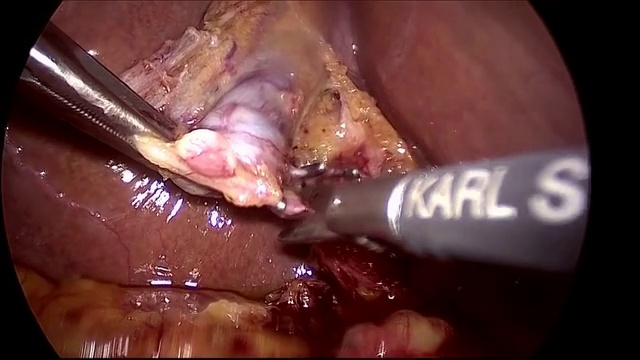

In [ ]:
val_frames[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
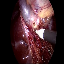

In [ ]:
resized_frames_test[0]

#3D CNN
Accuracy: 0.75

In [ ]:
!pip install einops

In [ ]:
!pip install seaborn

In [ ]:
import keras
from keras import layers

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
def add_residual_block(input, filters, kernel_size):
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [ ]:
input_shape = (None, 1, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2)(x)

model = keras.Model(input, x)

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

In [ ]:
import numpy as np

# Convert lists of images to numpy arrays
train_frames = np.array(resized_frames_train)
val_frames = np.array(resized_frames_val)

# Normalize pixel values to the range [0, 1]
train_frames = train_frames.astype('float32') / 255.0
val_frames = val_frames.astype('float32') / 255.0

# Ensure all images have the same dimensions
# Assuming images are already resized appropriately

# Reshape the input data to include the batch dimension (if necessary)
train_frames = np.expand_dims(train_frames, axis=1)  # Add a single channel dimension
val_frames = np.expand_dims(val_frames, axis=1)

train_labels_array = np.array(train_labels_list)
val_labels_array = np.array(val_labels_list)

In [ ]:
test_frames = np.array(resized_frames_test)
test_frames = test_frames.astype('float32') / 255.0
test_frames = np.expand_dims(test_frames, axis=1)
test_labels_array = np.array(test_labels_list)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
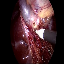

In [ ]:
resized_frames_test[0]

In [ ]:
model.build(train_frames)

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(x=train_frames, y=train_labels_array, epochs=30, validation_data=(val_frames, val_labels_array))


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_frames, test_labels_array)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


#3D CNN on batches of 10
Accuracy: 0.18


In [ ]:
!pip install einops

In [ ]:
!pip install seaborn

In [ ]:
import keras
from keras import layers

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
def add_residual_block(input, filters, kernel_size):
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [ ]:
input_shape = (None, 1, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2)(x)

model = keras.Model(input, x)

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

In [ ]:
import numpy as np

# Convert lists of images to numpy arrays
train_frames = np.array(resized_frames_train)
val_frames = np.array(resized_frames_val)

# Normalize pixel values to the range [0, 1]
train_frames = train_frames.astype('float32') / 255.0
val_frames = val_frames.astype('float32') / 255.0

# Ensure all images have the same dimensions
# Assuming images are already resized appropriately

# Reshape the input data to include the batch dimension (if necessary)
train_frames = np.expand_dims(train_frames, axis=1)  # Add a single channel dimension
val_frames = np.expand_dims(val_frames, axis=1)

train_labels_array = np.array(train_labels_list)
val_labels_array = np.array(val_labels_list)

In [ ]:
test_frames = np.array(resized_frames_test)
test_frames = test_frames.astype('float32') / 255.0
test_frames = np.expand_dims(test_frames, axis=1)
test_labels_array = np.array(test_labels_list)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
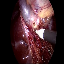

In [ ]:
resized_frames_test[0]

In [ ]:
model.build(train_frames)

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [ ]:
# Assuming you have train_frames (input frames) and train_labels_array (labels) prepared

# Reshape input frames into sequences of 10 frames each
num_samples = len(train_frames)
num_sequences = num_samples // 10
input_sequences = train_frames[:num_sequences*10].reshape((num_sequences, 10, HEIGHT, WIDTH, 3))

# Reshape labels to correspond to the output of each sequence
output_labels = train_labels_array[:num_sequences]

# Train the model using the input sequences and output labels
history = model.fit(x=input_sequences, y=output_labels, epochs=30, validation_data=(val_frames, val_labels_array))


In [ ]:
#history = model.fit(x=train_frames, y=train_labels_array, epochs=30, validation_data=(val_frames, val_labels_array))


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_frames, test_labels_array)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


#CNN+LSTM Model
Accuracy: 0.77


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Flatten, Dense

# Define the model
model = Sequential()

# CNN layers
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(1, HEIGHT, WIDTH, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))  # Return_sequences=False means it returns output only at the last time step

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for smoke/non-smoke classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeD  (None, 1, 62, 62, 32)     896       
 istributed)                                                     
                                                                 
 time_distributed_24 (TimeD  (None, 1, 31, 31, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 1, 29, 29, 64)     18496     
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 1, 14, 14, 64)     0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 1, 12, 12, 128)  

In [ ]:
history = model.fit(x=train_frames, y=train_labels_array, epochs=15, validation_data=(val_frames, val_labels_array))


Epoch 1/15
54/54 [==============================] - 4s 37ms/step - loss: 0.4951 - accuracy: 0.8041 - val_loss: 0.5691 - val_accuracy: 0.7619
Epoch 2/15
54/54 [==============================] - 1s 26ms/step - loss: 0.4835 - accuracy: 0.8140 - val_loss: 0.5486 - val_accuracy: 0.7619
Epoch 3/15
54/54 [==============================] - 1s 26ms/step - loss: 0.4578 - accuracy: 0.8140 - val_loss: 0.5591 - val_accuracy: 0.7619
Epoch 4/15
54/54 [==============================] - 1s 24ms/step - loss: 0.3499 - accuracy: 0.8180 - val_loss: 0.6018 - val_accuracy: 0.7190
Epoch 5/15
54/54 [==============================] - 1s 24ms/step - loss: 0.2912 - accuracy: 0.8558 - val_loss: 0.7206 - val_accuracy: 0.7238
Epoch 6/15
54/54 [==============================] - 1s 25ms/step - loss: 0.1881 - accuracy: 0.9279 - val_loss: 0.8393 - val_accuracy: 0.8286
Epoch 7/15
54/54 [==============================] - 1s 24ms/step - loss: 0.0944 - accuracy: 0.9709 - val_loss: 0.8901 - val_accuracy: 0.8000
Epoch 8/15
54

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_frames, test_labels_array)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


8/8 [==============================] - 0s 9ms/step - loss: 1.3091 - accuracy: 0.7652
Test Loss: 1.30907142162323
Test Accuracy: 0.7652173638343811


#ResNet
Accuracy: 0.80

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Flatten, Dense

# Load the pre-trained ResNet50 model without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained ResNet50 model as a layer in the Sequential model
model.add(TimeDistributed(base_model, input_shape=(1, HEIGHT, WIDTH, 3)))


# Add Flatten layer to convert the output shape to 3D
model.add(TimeDistributed(Flatten()))

# Add LSTM layer
model.add(LSTM(64, return_sequences=False))

# Add fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for smoke/non-smoke classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeD  (None, 1, 2, 2, 2048)     23587712  
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 1, 8192)           0         
 istributed)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 64)                2113792   
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25705729 (98.06 MB)
Trainable params: 21

In [ ]:
train_frames[0]

In [ ]:
import numpy as np

# Convert lists of images to numpy arrays
train_frames = np.array(resized_frames_train)
val_frames = np.array(resized_frames_val)

# Normalize pixel values to the range [0, 1]
train_frames = train_frames.astype('float32') / 255.0
val_frames = val_frames.astype('float32') / 255.0

# Ensure all images have the same dimensions
# Assuming images are already resized appropriately

# Reshape the input data to include the batch dimension (if necessary)
train_frames = np.expand_dims(train_frames, axis=1)  # Add a single channel dimension
val_frames = np.expand_dims(val_frames, axis=1)

train_labels_array = np.array(train_labels_list)
val_labels_array = np.array(val_labels_list)

In [ ]:
test_frames = np.array(resized_frames_test)
test_frames = test_frames.astype('float32') / 255.0
test_frames = np.expand_dims(test_frames, axis=1)
test_labels_array = np.array(test_labels_list)

#Movinet


In [ ]:
!pip install remotezip tqdm opencv-python opencv-python-headless tf-models-official

In [ ]:
# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
gru = layers.GRU(units=4, return_sequences=True, return_state=True)

inputs = tf.random.normal(shape=[1, 10, 8]) # (batch, sequence, channels)

result, state = gru(inputs) # Run it all at once

By setting the RNN's `return_sequences=True` argument you ask it to return the state at the end of the computation. This allows you to pause and then continue where you left off, to get exactly the same result:

![States passing in RNNs](https://www.tensorflow.org/images/tutorials/video/rnn_state_passing.png)

In [ ]:
first_half, state = gru(inputs[:, :5, :])   # run the first half, and capture the state
second_half, _ = gru(inputs[:,5:, :], initial_state=state)  # Use the state to continue where you left off.

print(np.allclose(result[:, :5,:], first_half))
print(np.allclose(result[:, 5:,:], second_half))

True
True


Causal convolutions can be used the same way, if handled with care. This technique was used in the [Fast Wavenet Generation Algorithm](https://arxiv.org/abs/1611.09482) by Le Paine et al. In the [MoVinet paper](https://arxiv.org/abs/2103.11511), the `state` is referred to as the "Stream Buffer".

![States passed in causal convolution](https://www.tensorflow.org/images/tutorials/video/causal_conv_states.png)

By passing this little bit of state forward, you can avoid recalculating the whole receptive field that shown above.

## Download a pre-trained MoViNet model

In this section, you will:

1. You can create a MoViNet model using the open source code provided in [`official/projects/movinet`](https://github.com/tensorflow/models/tree/master/official/projects/movinet) from TensorFlow models.
2. Load the pretrained weights.
3. Freeze the convolutional base, or all other layers except the final classifier head, to speed up fine-tuning.

To build the model, you can start with the `a0` configuration because it is the fastest to train when benchmarked against other models. Check out the [available MoViNet models on TensorFlow Model Garden](https://github.com/tensorflow/models/blob/master/official/projects/movinet/configs/movinet.py) to find what might work for your use case.

In [ ]:
model_id = 'a0'
resolution = 64

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


To build a classifier, create a function that takes the backbone and the number of classes in a dataset. The `build_classifier` function will take the backbone and the number of classes in a dataset to build the classifier. In this case, the new classifier will take a `num_classes` outputs (10 classes for this subset of UCF101).

In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [ ]:
batch_size = 8
num_frames = 10

In [ ]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 10)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

num_epochs = 2

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.rmsprop.RMSprop object at 0x7df6981ab3d0>

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

## Evaluate the model

The model achieved high accuracy on the training dataset. Next, use Keras `Model.evaluate` to evaluate it on the test set.

In [ ]:
model.evaluate(test_ds, return_dict=True)